(5492, 30)
[0 0 0 ..., 0 0 0]


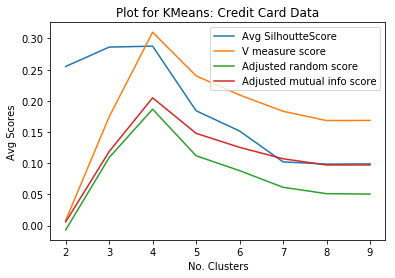

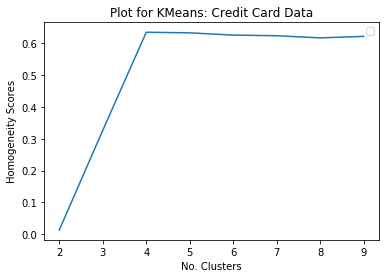

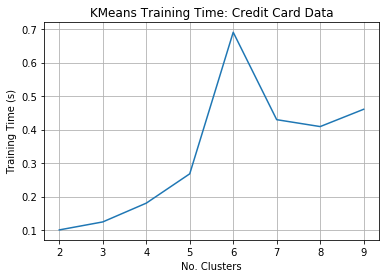

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.03
No. Iterations to Converge: 6
F1 Score:  0.68
Accuracy:  0.95     AUC:       0.76
Precision: 1.00     Recall:    0.52
*****************************************************


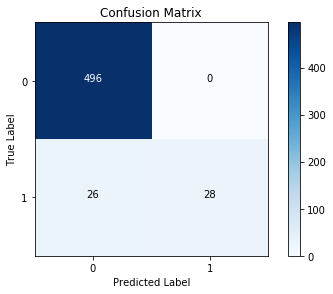

In [23]:
# # 3. Clustering

# ## k-Means Clustering

# This section will implement k-means clustering for both datasets. Our objectives are to:
# 1. Determine the best number of clusters for each dataset by using the elbow inspection method on silhouette score.
# 2. Describe the attributes which make up each cluster.
# 3. Score each cluster with an accuracy since technically we do have labels available for these datasets (labels are not used when determining clusters).
# 
# Since k-Means is susceptible to get stuck in local optima due to the random selection of initial cluster centers, I will report the average metrics over 5 models for each number of k clusters.

# In[9]:

import os
import pandas as pd
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier

from sklearn.externals.six import StringIO
from IPython.display import Image, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer,OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import metrics

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
def cluster_predictions(Y,clusterLabels):
#     print(type(Y),type(clusterLabels))
#     print(Y.shape,clusterLabels.shape)
#     print(Y,clusterLabels)

    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
#    assert max(pred) == max(Y)
#    assert min(pred) == min(Y)    
    return pred

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

np.random.seed(0)

def run_kmeans(X,y,title):

    kclusters = list(np.arange(2,10,1))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; completeness_score = []; v_measure_score=[];
    adjusted_rand_score=[]; adjusted_mutual_info_score=[];

    for k in kclusters:
        start_time = timeit.default_timer()
        km = KMeans(n_clusters=k, n_init=10,random_state=100,n_jobs=-1).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        
        sil_scores.append(sil_score(X, km.labels_))
        y_mode_vote = cluster_predictions(y,km.labels_)
        
        f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, km.labels_))
        
        completeness_score.append(metrics.completeness_score(y, km.labels_))
        v_measure_score.append(metrics.v_measure_score(y, km.labels_))
        adjusted_rand_score.append(metrics.adjusted_rand_score(y, km.labels_))
        adjusted_mutual_info_score.append(metrics.adjusted_mutual_info_score(y, km.labels_))
        

    fig = plt.figure()

    plt.plot(kclusters, sil_scores, label ='Avg SilhoutteScore')
    #plt.plot(kclusters, homo_scores, label ='Homogeneity Scores')
    #ax.plot(kclusters, completeness_score, label = 'Completeness Score')
    plt.plot(kclusters, v_measure_score, label='V measure score')
    plt.plot(kclusters, adjusted_rand_score, label='Adjusted random score')
    plt.plot(kclusters, adjusted_mutual_info_score, label = 'Adjusted mutual info score')


    #plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Avg Scores')
    plt.title('Plot for KMeans: '+ title)
    plt.legend()
    plt.show()
   
    plt.plot(kclusters, homo_scores)
    #plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Homogeneity Scores')
    plt.title('Plot for KMeans: '+ title)
    plt.legend()
    plt.show()
#     # plot homogeneity scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, homo_scores)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('Homogeneity Score')
#     plt.title('Homogeneity Scores KMeans: '+ title)
#     plt.show()
    
#         # elbow curve for silhouette score
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, completeness_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('completeness_score')
#     plt.title('completeness_score KMeans: '+ title)
#     plt.show()
   
#     # plot homogeneity scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, v_measure_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('v_measure_score ')
#     plt.title('v_measure_score  KMeans: '+ title)
#     plt.show()
    
#             # elbow curve for silhouette score
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, adjusted_rand_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('adjusted_rand_score')
#     plt.title('adjusted_rand_score KMeans: '+ title)
#     plt.show()
   
#     # plot homogeneity scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, v_measure_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('adjusted_mutual_info_score ')
#     plt.title('adjusted_mutual_info_score  KMeans: '+ title)
#     plt.show()

#     # plot f1 scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, f1_scores)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('F1 Score')
#     plt.title('F1 Scores KMeans: '+ title)
#     plt.show()

    # plot model training time
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, train_times)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Training Time (s)')
    plt.title('KMeans Training Time: '+ title)
    plt.show()
    
def evaluate_kmeans(km, X, y):
    start_time = timeit.default_timer()
    km.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    y_mode_vote = cluster_predictions(y,km.labels_)
    auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote)
    recall = recall_score(y, y_mode_vote)
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(km.n_iter_))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()


df = pd.read_csv("creditcard.csv")
df = df.sample(frac=1)
# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:5000]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
fraud_data = normal_distributed_df.sample(frac=1, random_state=42)


data = fraud_data.loc[:, fraud_data.columns != 'Class'] 
target = fraud_data.loc[:, fraud_data.columns == 'Class'] 
target = target.values
target = np.reshape(target, (len(target)))
print(data.shape)
# print(target.shape)
print(target)
#target = np.delete(target,0,0)
#target = target.as_matrix

# Initialize neural network object and fit object
X_train, X_test, y_train, y_test = train_test_split(data, target, \
                                                    test_size = 0.1, random_state = 3)

# Normalize feature data
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One hot encode target values
# one_hot = OneHotEncoder()

# y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
# y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()

#phishX,phishY,bankX,bankY = import_data()
#print(type(y_train))
run_kmeans(X_train_scaled,y_train,'Credit Card Data')
km = KMeans(n_clusters=2,n_init=10,random_state=100,n_jobs=-1)
evaluate_kmeans(km,X_test_scaled,y_test)
df = pd.DataFrame(km.cluster_centers_)
df.to_csv("Phishing kMeans Cluster Centers.csv")

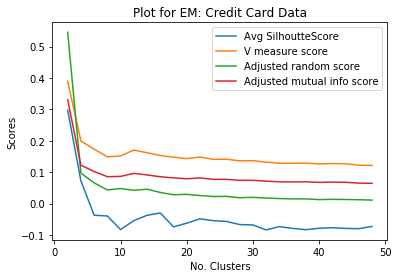

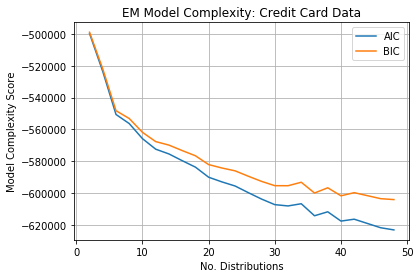

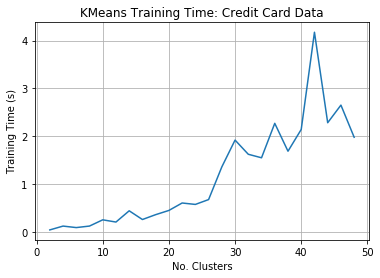

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.01
No. Iterations to Converge: 11
Log-likelihood Lower Bound: 48.77
F1 Score:  0.67
Accuracy:  0.92     AUC:       0.88
Precision: 0.56     Recall:    0.83
*****************************************************


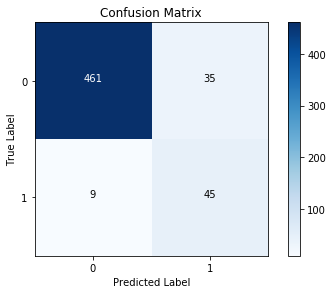

In [22]:
# ## Expectation Maximization

# This section will implement k-means clustering for both datasets. The same 3 objectives from k-means apply here.

# In[10]:


from sklearn.mixture import GaussianMixture as EM
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt

np.random.seed(0)

def run_EM(X,y,title):

    #kdist =  [2,3,4,5]
    #kdist = list(range(2,51))
    kdist = list(np.arange(2,50,2))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; completeness_score = []; v_measure_score=[];
    adjusted_rand_score=[]; adjusted_mutual_info_score=[]; aic_scores = []; bic_scores = []
    
    for k in kdist:
        start_time = timeit.default_timer()
        em = EM(n_components=k,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        
        labels = em.predict(X)
        sil_scores.append(sil_score(X, labels))
        y_mode_vote = cluster_predictions(y,labels)
        f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, labels))
        
        completeness_score.append(metrics.completeness_score(y, labels))
        v_measure_score.append(metrics.v_measure_score(y, labels))
        adjusted_rand_score.append(metrics.adjusted_rand_score(y, labels))
        adjusted_mutual_info_score.append(metrics.adjusted_mutual_info_score(y, labels))
        
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))

        
    plt.plot(kdist, sil_scores, label ='Avg SilhoutteScore')
    #plt.plot(kclusters, homo_scores, label ='Homogeneity Scores')
    #ax.plot(kclusters, completeness_score, label = 'Completeness Score')
    plt.plot(kdist, v_measure_score, label='V measure score')
    plt.plot(kdist, adjusted_rand_score, label='Adjusted random score')
    plt.plot(kdist, adjusted_mutual_info_score, label = 'Adjusted mutual info score')
    #plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Scores')
    plt.title('Plot for EM: '+ title)
    plt.legend()
    plt.show()
    
    
#     # elbow curve for silhouette score
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, sil_scores)
#     plt.grid(True)
#     plt.xlabel('No. Distributions')
#     plt.ylabel('Avg Silhouette Score')
#     plt.title('Elbow Plot for EM: '+ title)
#     plt.show()
   
#     # plot homogeneity scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, homo_scores)
#     plt.grid(True)
#     plt.xlabel('No. Distributions')
#     plt.ylabel('Homogeneity Score')
#     plt.title('Homogeneity Scores EM: '+ title)
#     plt.show()
    
#             # elbow curve for silhouette score
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, completeness_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('completeness_score')
#     plt.title('completeness_score KMeans: '+ title)
#     plt.show()
   
#     # plot homogeneity scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, v_measure_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('v_measure_score ')
#     plt.title('v_measure_score  KMeans: '+ title)
#     plt.show()
    
#             # elbow curve for silhouette score
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, adjusted_rand_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('adjusted_rand_score')
#     plt.title('adjusted_rand_score KMeans: '+ title)
#     plt.show()
   
#     # plot homogeneity scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, v_measure_score)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('adjusted_mutual_info_score ')
#     plt.title('adjusted_mutual_info_score  KMeans: '+ title)
#     plt.show()

#     # plot f1 scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, f1_scores)
#     plt.grid(True)
#     plt.xlabel('No. Distributions')
#     plt.ylabel('F1 Score')
#     plt.title('F1 Scores EM: '+ title)


#     plt.show()

    # plot model AIC and BIC
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, aic_scores, label='AIC')
    ax.plot(kdist, bic_scores,label='BIC')
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Model Complexity Score')
    plt.title('EM Model Complexity: '+ title)
    plt.legend(loc="best")
    plt.show()
    
        # plot model training time
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, train_times)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Training Time (s)')
    plt.title('EM Training Time: '+ title)
    plt.show()
    
    
def evaluate_EM(em, X, y):
    start_time = timeit.default_timer()
    em.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    labels = em.predict(X)
    y_mode_vote = cluster_predictions(y,labels)
    auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote)
    recall = recall_score(y, y_mode_vote)
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(em.n_iter_))
    print("Log-likelihood Lower Bound: {:.2f}".format(em.lower_bound_))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()


run_EM(X_train_scaled,y_train,'Credit Card Data')
em = EM(n_components=2,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,X_test_scaled,y_test)
df = pd.DataFrame(em.means_)
df.to_csv("Phishing EM Component Means.csv")


# In[ ]:


# phishX,phishY,bankX,bankY = import_data()
# X_train, X_test, y_train, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.25)
# run_EM(X_train,y_train,'Banking Data')
# em = EM(n_components=41,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
# evaluate_EM(em,bankX,bankY)
# df = pd.DataFrame(em.means_)
# df.to_csv("Banking EM Component Means.csv")

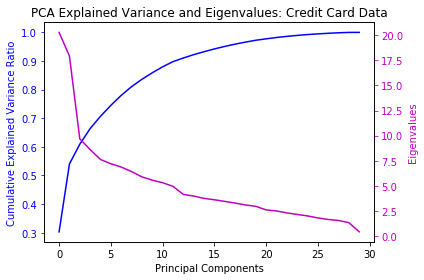

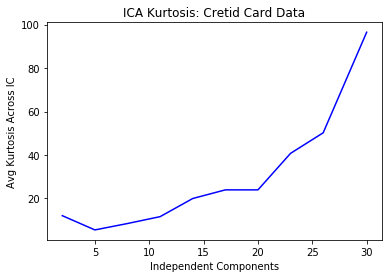

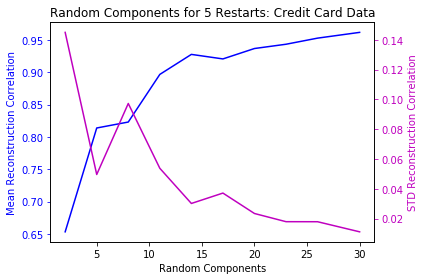

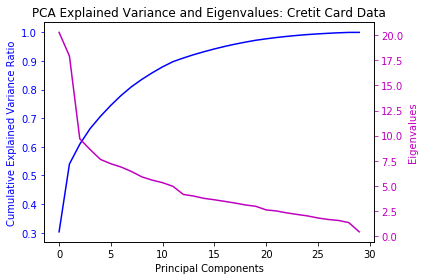

In [8]:
# # 4. Dimensionality Reduction

# This section will implement 4 different dimensionality reduction techniques on both the phishing and the banking dataset. Then, k-means and EM clustering will be performed for each (dataset * dim_reduction) combination to see how the clustering compares with using the full datasets. The 4 dimensionality reduction techniques are:
# - Principal Components Analysis (PCA). Optimal number of PC chosen by inspecting % variance explained and the eigenvalues.
# - Independent Components Analysis (ICA). Optimal number of IC chosen by inspecting kurtosis.
# - Random Components Analysis (RCA) (otherwise known as Randomized Projections). Optimal number of RC chosen by inspecting reconstruction error.
# - Random Forest Classifier (RFC). Optimal number of components chosen by feature importance.

# In[11]:


from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from itertools import product
from collections import defaultdict

def run_PCA(X,y,title):
    
    pca = PCA(random_state=5).fit(X) #for all components
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-')
    ax1.set_xlabel('Principal Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'm-')
    ax2.set_ylabel('Eigenvalues', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("PCA Explained Variance and Eigenvalues: "+ title)
    fig.tight_layout()
    plt.show()
    
def run_ICA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    ica = ICA(random_state=5)
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

def run_RCA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)

    for i,dim in product(range(5),dims):
        rp = RCA(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()
    
def run_RFC(X,y,df_original):
    rfc = RFC(n_estimators=500,min_samples_leaf=round(len(X)*.01),random_state=5,n_jobs=-1)
    imp = rfc.fit(X,y).feature_importances_ 
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=df_original.columns[2::])
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=0.95]
    top_cols = imp.index.tolist()
    return imp, top_cols


# In[56]:

run_PCA(X_train_scaled,y_train,'Credit Card Data')
run_ICA(X_train_scaled,y_train,'Cretid Card Data')
run_RCA(X_train_scaled,y_train,'Credit Card Data')
run_PCA(X_train_scaled,y_train,'Cretit Card Data')
